# Imports

In [214]:
import json
import os
import bz2
import io
from bz2 import BZ2File
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta

import seaborn as sns
sns.set_context('paper')
sns.set_style("white")
sns.set(rc = {'figure.figsize':(12,8)})

# Charger le dataset

In [2]:
df = pd.read_json('cleaned.json.bz2', compression = 'bz2')
df['journal'] = df['journal'].astype('category')
df.head()

,id,journal,date,page,ppage,text,length
0,0,JDG,1978-12-29,1,NaN,Algérie : l'arbitrage sans arbitre Pour un Eta...,3777
1,1,JDG,1978-12-29,3,NaN,ALORS QUE LA FOULE ENTERRE SES DERNIERES VICTI...,3401
100,100,JDG,1978-06-13,1,NaN,La Ruhr chinoise s'ouvre à l'Occident Gilbert ...,6017
10000,10000,JDG,1978-10-25,11,NaN,Selon le président du directoire de la Banque ...,4345
100000,100000,GDL,1976-10-05,2,NaN,TÉLÉVISION-RADIO SELECTION-TV Antenne 2 20.30 ...,7976


In [3]:
df = df.drop(columns = 'id')

In [4]:
df.index = np.arange(len(df))

# Nettoyage ciblé

In [5]:
def keywords_count(df, keywords):
    """ Select text that contains certain keywords and count the latter """
    
    counts, k = [], []
    
    for keyword in keywords:
        k.append(keyword.lower())
    
    for ind, row in df.iterrows():
        
        counts_ = []
        for k_ in k:
            counts_.append(len(re.findall(k_, row['text'].lower())))
        
        counts.append(counts_)
                
    return counts

In [6]:
garbage = ['tableau hebdomadaire',
           'aetoa',
           'sopacx',
           'cotées en suisse',
           'new york stock exch',
           'new york nys']

In [7]:
counts_garbage = keywords_count(df, garbage)
counts_garbage = np.asarray(counts_garbage).T

In [8]:
for i in range(len(garbage)):
    df['keyword_' + garbage[i]] = counts_garbage[i]

In [9]:
for i in range (len(garbage)):
    df = df[df['keyword_' + garbage[i]] == 0]

In [10]:
len(df)

450630

# Isoler le corpus pour la dernière couche de nettoyage ciblée

In [11]:
keywords = ['pétrol', 
            'opep', 
            'organisation des pays exportateurs de pétrole',
            'shell',
            'tamoil',
            'petrol',
            'petroleum',
            'texaco',
            'standard oil',
            'exxon',
            'gulf oil',
            'ats',
            'afp',
            'reuter',
            'reuther']

In [12]:
counts = keywords_count(df, keywords)
counts = np.asarray(counts).T

In [13]:
for i in range(len(keywords)):
    df['keyword_' + keywords[i]] = counts[i]

In [14]:
df['keywords_petrole'] = df['keyword_pétrol'] + df['keyword_petrol']
df['keywords_OPEP'] = df['keyword_opep'] + \
    df['keyword_organisation des pays exportateurs de pétrole']
df['keywords_compagnies'] = df['keyword_shell'] + \
    df['keyword_tamoil'] + df['keyword_petroleum'] + df['keyword_texaco'] + \
    df['keyword_standard oil'] + df['keyword_exxon'] + df['keyword_gulf oil']
df['keywords'] = df['keywords_petrole'] + df['keywords_OPEP'] + \
    df['keywords_compagnies']

df['depeches'] = df['keyword_afp'] + df['keyword_ats'] + df['keyword_reuther'] + df['keyword_reuter']

In [15]:
df_corpus = df[df['keywords'] > 0]

# Nettoyage post-filtrage

In [16]:
df_depeches = df_corpus[df_corpus['depeches'] > 0]
df_not_depeches = df_corpus[df_corpus['depeches'] == 0]

In [17]:
len(df_depeches)

21746

In [116]:
def compare_texts(txt1, txt2):
    
    identical = False
    recover = 0
        
    ### First step is a rough assessment ###
    
    text1 = txt1.split(' ')
    text2 = txt2.split(' ')
    
    if (len(text1) > 20) and (len(text2) > 20):
        text1, text2 = text1[:20], text2[:20]
        
    else:
        min_ = min(len(text1), len(text2))
        text1, text2 = text1[:min_], text2[:min_]
        
    if set(text1) == set(text2):
        return True
    
    differentials, grade = [], 0
    
    # estimate identity 
    for i in range(len(text1)):
        for j in range(len(text2)):
            if text1[i] == text2[j]:
                grade += 1
                differentials.append(j - i)
    
    _ = np.unique(differentials, return_counts = True)
    
    if len(_[1]) == 0:
        return False
    
    else:
            
        ### Second step is a finer assessment ###
        if (grade >= 12) and (np.argmax(_[1].tolist()) >= 12): 
            
            if (len(text1) > 50) and (len(text2) > 50):
                text1, text2 = text1[:50], text2[:50]
                
                differentials, grade = [], 0
                
                for i in range(len(text1)):
                    for j in range(len(text2)):
                        if text1[i] == text2[j]:
                            grade += 1
                            differentials.append(j - i)
                            
                _ = np.unique(differentials, return_counts = True)
                
                if (grade >= 40) and (np.argmax(_[1].tolist()) >= 40):
                    return True

            else:
                return True
    
        else:
            return False

In [117]:
def check_duplicates(df):

    first_day = min(df_depeches['date'])
    last_day = max(df_depeches['date'])
    day = first_day
    
    duplicates, checked = [], []

    while day <= last_day:
        border = [day - timedelta(days = 7), day + timedelta(days = 7)]
        df_1 = df[df['date'] == day] # ?
        df_2 = df[df['date'] >= border[0]]
        df_2 = df_2[df_2['date'] <= border[1]]
        
        for ind_1, row_1 in df_1.iterrows():
            for ind_2, row_2 in df_2.iterrows():
                
                if not(ind_2 in checked):
                    if (ind_1 != ind_2) and compare_texts(row_1['text'], row_2['text']):
                        duplicates.append([ind_1, ind_2])
            
            checked.append(ind_1)
        
        day += timedelta(days = 1)
        
    return duplicates
            

In [72]:
df_ats = df_corpus[df_corpus['keyword_ats'] > 0]
df_reuter = df_corpus[df_corpus['keyword_reuter'] > 0]
df_reuther = df_corpus[df_corpus['keyword_reuther'] > 0]
df_afp = df_corpus[df_corpus['keyword_afp'] > 0]

In [91]:
duplicates = check_duplicates(df_reuther)
duplicates += check_duplicates(df_reuter)

In [92]:
duplicates += check_duplicates(df_afp)

In [93]:
duplicates += check_duplicates(df_ats)

In [120]:
to_drop = []

for i in range(len(duplicates)):
    if not(duplicates[i][0] in to_drop) and not(duplicates[i][1] in to_drop):
        to_drop.append(duplicates[i][0])

In [121]:
len(to_drop)

1985

In [126]:
df_corpus_unique = df_corpus.drop(to_drop)

In [127]:
len(df_corpus)

27786

In [128]:
len(df_corpus_unique)

25801

In [129]:
df_corpus_unique.to_json('corpus_unique.json.bz2', compression = 'bz2')

In [137]:
df_corpus_unique = pd.read_json('corpus_unique.json.bz2', compression = 'bz2')
df_corpus_unique['journal'] = df_corpus_unique['journal'].astype('category')
df_corpus_unique.index = np.arange(len(df_corpus_unique))


In [138]:
df = df_corpus_unique.drop(columns = ['keyword_tableau hebdomadaire', 'keyword_aetoa', 'keyword_sopacx',
                                      'keyword_cotées en suisse', 'keyword_new york stock exch',
                                      'keyword_new york nys'])

# Création des sous-corpus

In [139]:
keywords = ['pétrol', 
            'opep', 
            'organisation des pays exportateurs de pétrole',
            'shell',
            'tamoil',
            'petrol',
            'petroleum',
            'texaco',
            'standard oil',
            'exxon',
            'gulf oil',
            'ats',
            'afp',
            'reuter',
            'reuther']

In [140]:
counts = keywords_count(df, keywords)
counts = np.asarray(counts).T

In [141]:
for i in range(len(keywords)):
    df['keyword_' + keywords[i]] = counts[i]

In [142]:
df['keywords_petrole'] = df['keyword_pétrol'] + df['keyword_petrol']
df['keywords_OPEP'] = df['keyword_opep'] + \
    df['keyword_organisation des pays exportateurs de pétrole']
df['keywords_compagnies'] = df['keyword_shell'] + \
    df['keyword_tamoil'] + df['keyword_petroleum'] + df['keyword_texaco'] + \
    df['keyword_standard oil'] + df['keyword_exxon'] + df['keyword_gulf oil']
df['keywords'] = df['keywords_petrole'] + df['keywords_OPEP'] + \
    df['keywords_compagnies']

df['depeches'] = df['keyword_afp'] + df['keyword_ats'] + df['keyword_reuther'] + df['keyword_reuter']

In [143]:
df_corpus = df[df['keywords'] > 0]

# Sauvegarde des sous-corpus

In [144]:
df_corpus_OPEP = df_corpus[df_corpus['keywords_OPEP'] > 0]
df_corpus_petrole = df_corpus[df_corpus['keywords_petrole'] > 0]
df_corpus_compagnies = df_corpus[df_corpus['keywords_compagnies'] > 0]

In [145]:
df_corpus.to_json('corpus.json.bz2', compression = 'bz2')
df_corpus_OPEP.to_json('corpus_OPEP.json.bz2', compression = 'bz2')
df_corpus_petrole.to_json('corpus_petrole.json.bz2', compression = 'bz2')
df_corpus_compagnies.to_json('corpus_compagnies.json.bz2', compression = 'bz2')

In [146]:
df_depeches.to_json('corpus_depeches.json.bz2', compression = 'bz2')
df_not_depeches.to_json('corpus_not_depeches.json.bz2', compression = 'bz2')

In [147]:
df_corpus = pd.read_json('corpus.json.bz2', compression = 'bz2')
df_corpus_OPEP = pd.read_json('corpus_OPEP.json.bz2', compression = 'bz2')
df_corpus_petrole = pd.read_json('corpus_petrole.json.bz2', compression = 'bz2')
df_corpus_compagnies = pd.read_json('corpus_compagnies.json.bz2', compression = 'bz2')

In [148]:
df_corpus['journal'] = df_corpus['journal'].astype('category')
df_corpus_OPEP['journal'] = df_corpus_OPEP['journal'].astype('category')
df_corpus_petrole['journal'] = df_corpus_petrole['journal'].astype('category')
df_corpus_compagnies['journal'] = df_corpus_compagnies['journal'].astype('category')

df_corpus.index = np.arange(len(df_corpus))
df_corpus_OPEP.index = np.arange(len(df_corpus_OPEP))
df_corpus_petrole.index = np.arange(len(df_corpus_petrole))
df_corpus_compagnies.index = np.arange(len(df_corpus_compagnies))

# Analyse exploratoire

In [149]:
df_corpus_petrole.head()

,journal,date,page,ppage,text,length,keyword_pétrol,keyword_opep,keyword_organisation des pays exportateurs de pétrole,keyword_shell,...,keyword_gulf oil,keyword_ats,keyword_afp,keyword_reuter,keyword_reuther,keywords_petrole,keywords_OPEP,keywords_compagnies,keywords,depeches
0,JDG,1974-01-07,2,NaN,"Pétrole : "" (déjà 50000 la crise continue chôm...",3465,6,5,0,0,...,0,2,1,0,0,6,5,0,11,3
1,JDG,1974-01-07,2,NaN,''« Je vendrai'Le chah d Iran : de l aspirine ...,1976,6,0,0,0,...,0,0,1,0,0,7,0,0,7,1
2,JDG,1978-11-01,5,NaN,ENVIRONNEMENT NOUVEAU PROCÉDÉ DE LUTTE CONTRE ...,255,2,0,0,0,...,0,0,0,0,0,2,0,0,2,0
3,JDG,1974-10-12,5,NaN,En septembre Déficit de la balance britannique...,1868,3,0,0,0,...,0,2,1,0,0,3,0,0,3,3
4,JDG,1973-10-10,7,NaN,"BOURSES EUROPÉENNES BALE, GENÈVE, ZURICH. — La...",4374,1,0,0,0,...,0,0,0,0,0,1,0,1,2,0


In [150]:
len(df_corpus)

25801

In [151]:
len(df_corpus_OPEP)

2862

In [152]:
len(df_corpus_petrole)

24041

In [153]:
len(df_corpus_compagnies)

6238

In [154]:
len(df_depeches)

21746

In [155]:
len(df_not_depeches)

6040

In [218]:
sns.set_style("ticks")

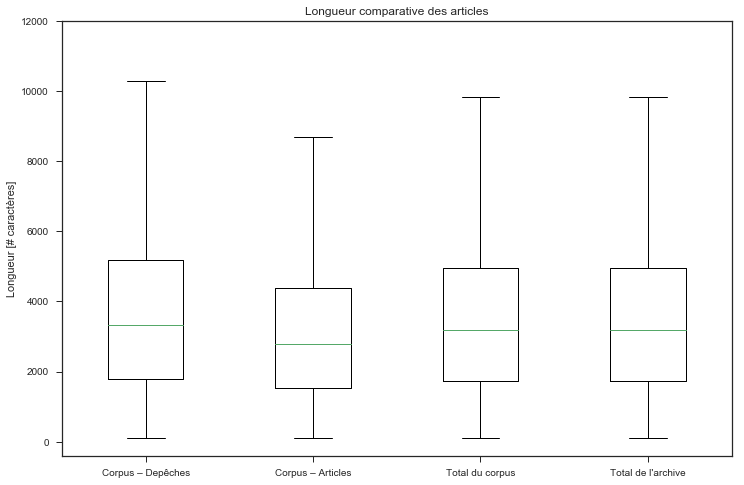

In [273]:
plt.boxplot([np.array(df_depeches['length']), 
             np.array(df_not_depeches['length']),
             np.array(df_corpus['length']),
             np.array(df['length'])]);

plt.xticks([1,2,3,4], np.array(['Corpus – Depêches', 'Corpus – Articles', 
                                'Total du corpus', "Total de l\'archive"]))
plt.ylabel('Longueur [# caractères]');
plt.ylim((-400,12000))
plt.title('Longueur comparative des articles');
plt.show()

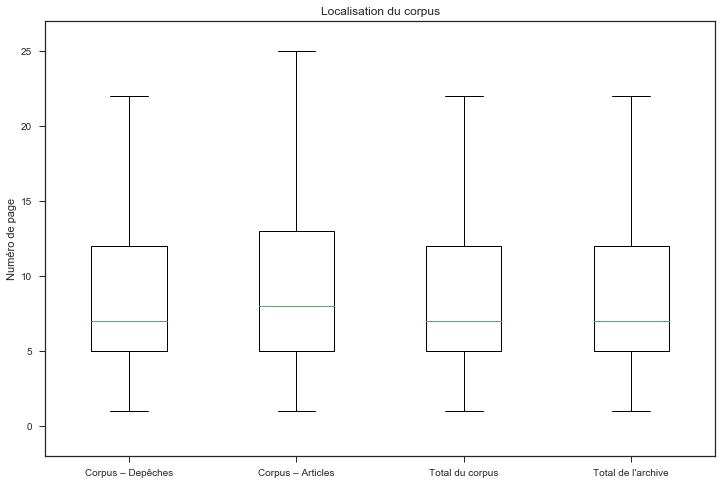

In [275]:
plt.boxplot([(np.append(df_depeches['page'], df_depeches['ppage'].dropna())), 
             (np.append(df_not_depeches['page'], df_not_depeches['ppage'].dropna())),
             (np.append(df_corpus['page'], df_corpus['ppage'].dropna())),
             (np.append(df['page'], df['ppage'].dropna()))]);

plt.xticks([1,2,3,4], np.array(['Corpus – Depêches', 'Corpus – Articles', 
                                'Total du corpus', "Total de l\'archive"]))
plt.ylabel('Numéro de page');
plt.ylim((-2,27))
plt.title('Localisation du corpus');
plt.show()

In [193]:
publication_time = []

for ind, row in df_corpus.iterrows():
    publication_time.append(row['date'].year + row['date'].month/12 - 1/24)
    
df_corpus['publication_time'] = publication_time

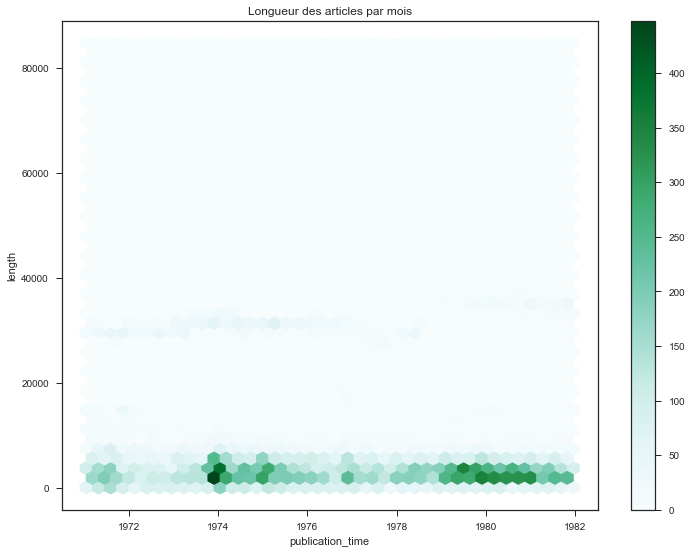

In [279]:
df_corpus.plot(kind='hexbin', x='publication_time', y='length', gridsize=40, 
                title = 'Longueur des articles par mois', figsize = (12,9), sharex=False);

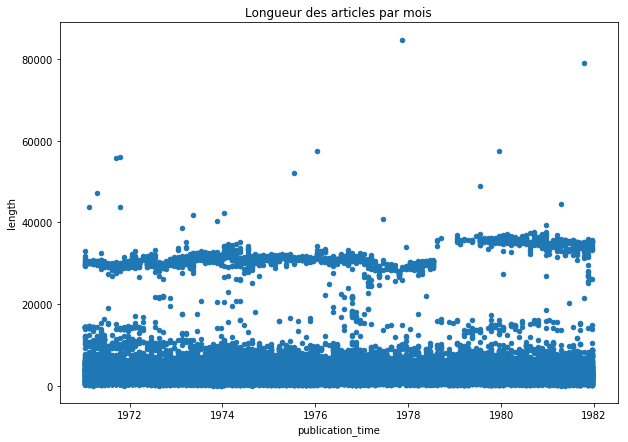

In [162]:
df_corpus.plot(kind='scatter', x='publication_time', y='length', 
                title = 'Longueur des articles par mois', figsize = (10,7), sharex=False);

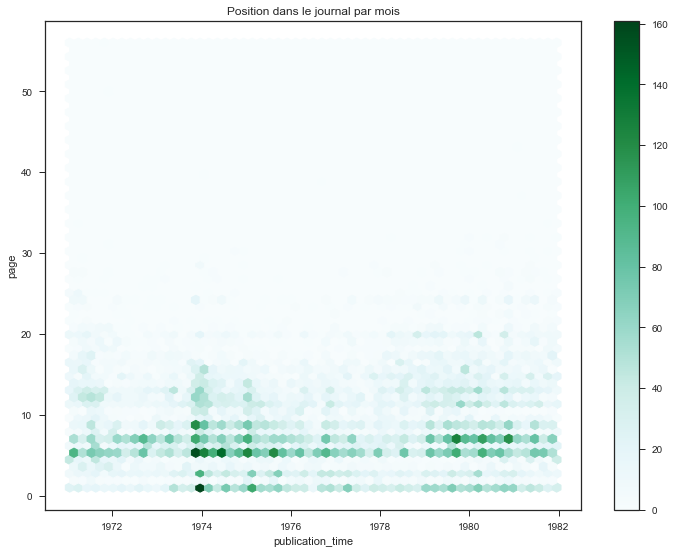

In [277]:
df_corpus.plot(kind='hexbin', x='publication_time', y='page', gridsize = 56, 
                title = 'Position dans le journal par mois', figsize = (12,9), sharex=False);

In [165]:
df_corpus_per_month = df_corpus.groupby(['publication_time']).sum()

In [166]:
df_corpus_per_month.head()

,page,ppage,length,keyword_pétrol,keyword_opep,keyword_organisation des pays exportateurs de pétrole,keyword_shell,keyword_tamoil,keyword_petrol,keyword_petroleum,...,keyword_gulf oil,keyword_ats,keyword_afp,keyword_reuter,keyword_reuther,keywords_petrole,keywords_OPEP,keywords_compagnies,keywords,depeches
publication_time,,,,,,,,,,,,,,,,,,,,,
1971.041667,1559,7.0,1072091,435,79,7,56,0,44,19,...,14,289,65,4,0,479,86,151,716,358
1971.125000,1551,9.0,999279,520,82,6,64,0,49,26,...,11,236,101,7,0,569,88,154,811,344
1971.208333,1525,25.0,1054086,369,4,2,64,0,48,25,...,6,232,90,20,0,417,6,131,554,342
1971.291667,2894,20.0,1392512,556,7,2,107,0,65,25,...,13,287,94,11,0,621,9,208,838,392
1971.375000,2318,0.0,1135101,262,2,1,97,0,41,5,...,28,234,29,7,0,303,3,179,485,270


In [167]:
df_corpus_per_month['time'] = df_corpus_per_month.index

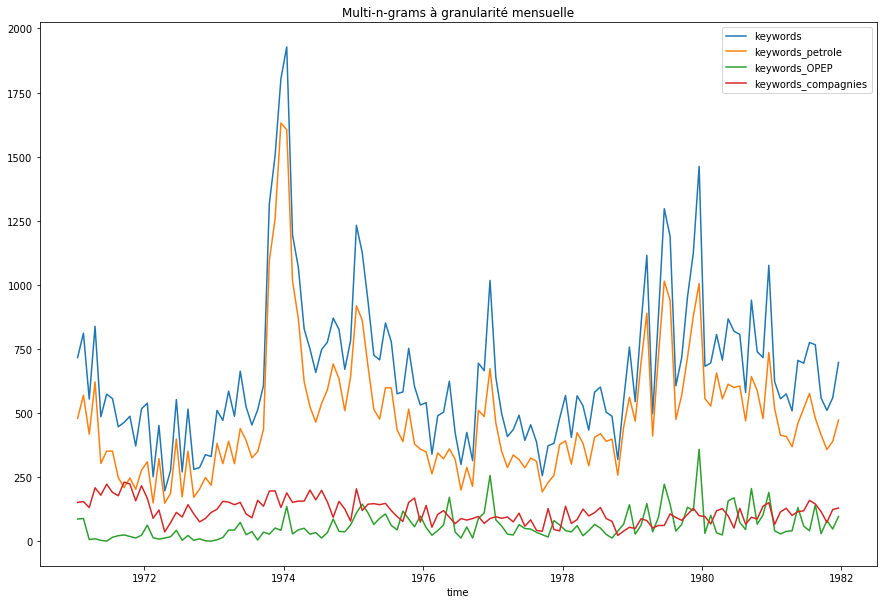

In [168]:
df_corpus_per_month.plot(x='time', y=['keywords', 'keywords_petrole', 'keywords_OPEP', 'keywords_compagnies'],
                title = 'Multi-n-grams à granularité mensuelle', figsize = (15,10), sharex=False);

# Export au format Iramuteq

In [169]:
df_corpus_OPEP.head()

,journal,date,page,ppage,text,length,keyword_pétrol,keyword_opep,keyword_organisation des pays exportateurs de pétrole,keyword_shell,...,keyword_gulf oil,keyword_ats,keyword_afp,keyword_reuter,keyword_reuther,keywords_petrole,keywords_OPEP,keywords_compagnies,keywords,depeches
0,JDG,1974-01-07,2,NaN,"Pétrole : "" (déjà 50000 la crise continue chôm...",3465,6,5,0,0,...,0,2,1,0,0,6,5,0,11,3
1,GDL,1979-11-27,13,NaN,Ryad ne garantit pas sa production pétrolière ...,1116,2,1,0,0,...,0,0,0,0,0,2,1,0,3,0
2,GDL,1979-10-18,9,NaN,Ventes d'or américaines : surprise LUTTE CONTR...,3411,8,1,1,0,...,0,4,1,0,0,8,2,0,10,5
3,GDL,1979-04-05,13,NaN,CARNET DU JEUDI • Son Altesse royale le prince...,3316,2,1,0,0,...,0,0,0,0,0,2,1,0,3,0
4,GDL,1979-04-06,20,NaN,Allemagne Un mois encore faible La tendance de...,3715,1,2,0,0,...,0,2,0,0,0,1,2,0,3,2


In [261]:
def formate_text(df):
    
    text = ''
    for row in df.iterrows():
        text += '**** *' + row[1][0] + ' *' + \
            str(row[1][1])[:10] + ' *' + str(row[1][2]) + ' *' + \
            str(row[1][5]) + '\n' + row[1][4] + '\n'
        
    return text

In [264]:
def iramuteq_export(df, filename):
    
    text = formate_text(df)
    file = open(filename,'w') 
    file.write(text)
    file.close()
    
    return True

In [266]:
iramuteq_export(df_corpus, 'corpus.txt')
iramuteq_export(df_corpus_OPEP, 'corpus_opep.txt')
iramuteq_export(df_corpus_petrole, 'corpus_petrole.txt')
iramuteq_export(df_corpus_compagnies, 'corpus_compagnies.txt')
iramuteq_export(df_depeches, 'depeches.txt')
iramuteq_export(df_not_depeches, 'not_depeches.txt')

True